## Library import

### If you are using the github notebook use this line to unzip the samples archieve

In [ ]:
#!unzip samples.zip

For usage of CER need to install fastwer (yeah I am too lazy to write easy dp)

In [2]:
pip install fastwer

  Preparing metadata (setup.py) ... done
  Created wheel for fastwer: filename=fastwer-0.1.3-cp37-cp37m-linux_x86_64.whl size=916340 sha256=0e738c6e12b6485361c3e1eac51b4749a39d6a34a5e16f29e972deabc764c30b
  Stored in directory: /root/.cache/pip/wheels/c8/b6/93/419e758f0c0176d311602763520bcfdec18107be1f15186fe6
Successfully built fastwer
Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from torch.nn import functional
import numpy as np
import pandas as pd
import fastwer

Defining some hyperparameters

In [4]:
data_path  = "samples"
split_frac = 0.20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
img_shape = ()

## Dataset class
 - loading data from the directory
 - Calculating the image shape and symbols occuring in the dataset

In [89]:

class ImageData(Dataset):
    def load_image(self, path):
        img = Image.open(path).convert('RGB')
        trans = transforms.ToPILImage()
        trans1 = transforms.ToTensor()
        res = trans1(img)
        return  res

    def get_label(self, filename):
            label = filename.split('.')[0]
            self.symbols.update(set(list(label)))
            return label 

    def __init__(self, data_path):
        self.samples = []
        self.symbols = set()
        self.img_shape = None
        super(self.__class__, self).__init__()
        for filename in os.listdir(data_path):
            if filename != 'samples':
                file_path = data_path + "/" + filename
                print(f"processing {file_path}")
                image = self.load_image(file_path)
                self.img_shape = tuple(image.shape)
                image_label = self.get_label(filename)
                self.samples.append((image, image_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [102]:
dataset = ImageData(data_path)
img_shape = dataset.img_shape
classes = list(dataset.symbols)


processing /kaggle/input/captcha-version-2-images/samples/6n6gg.png
processing /kaggle/input/captcha-version-2-images/samples/fncnb.png
processing /kaggle/input/captcha-version-2-images/samples/nxf2c.jpg
processing /kaggle/input/captcha-version-2-images/samples/nbwnn.png
processing /kaggle/input/captcha-version-2-images/samples/ebcbx.png
processing /kaggle/input/captcha-version-2-images/samples/nxn4f.png
processing /kaggle/input/captcha-version-2-images/samples/2en7g.png
processing /kaggle/input/captcha-version-2-images/samples/y866y.png
processing /kaggle/input/captcha-version-2-images/samples/xcmbp.png
processing /kaggle/input/captcha-version-2-images/samples/g247w.png
processing /kaggle/input/captcha-version-2-images/samples/56ncx.png
processing /kaggle/input/captcha-version-2-images/samples/n8wxm.jpg
processing /kaggle/input/captcha-version-2-images/samples/6ng6n.png
processing /kaggle/input/captcha-version-2-images/samples/x362g.png
processing /kaggle/input/captcha-version-2-image

In [103]:
# adding - this is important and it should be first !!! or the length would be fitted with trash
classes= ['-'] + classes
classes_num = len(classes)
classes

['-',
 '8',
 'p',
 'c',
 '6',
 '5',
 'e',
 'd',
 '4',
 'f',
 'w',
 'x',
 'y',
 'b',
 '3',
 'n',
 '2',
 '7',
 'g',
 'm']

In [104]:
idx2char = {k:v for k,v in enumerate(classes, start=0)}
char2idx = {v:k for k,v in idx2char.items()}
print(idx2char)
print(char2idx)

{0: '-', 1: '8', 2: 'p', 3: 'c', 4: '6', 5: '5', 6: 'e', 7: 'd', 8: '4', 9: 'f', 10: 'w', 11: 'x', 12: 'y', 13: 'b', 14: '3', 15: 'n', 16: '2', 17: '7', 18: 'g', 19: 'm'}
{'-': 0, '8': 1, 'p': 2, 'c': 3, '6': 4, '5': 5, 'e': 6, 'd': 7, '4': 8, 'f': 9, 'w': 10, 'x': 11, 'y': 12, 'b': 13, '3': 14, 'n': 15, '2': 16, '7': 17, 'g': 18, 'm': 19}


Some statistics

In [105]:
print(f"total number of samples = {len(dataset)}")
print(f"shape of each image is {img_shape}")
print(f"symbols to recognize are {classes}, \nwhich is in total {len(classes)} elements")

total number of samples = 1070
shape of each image is (3, 50, 200)
symbols to recognize are ['-', '8', 'p', 'c', '6', '5', 'e', 'd', '4', 'f', 'w', 'x', 'y', 'b', '3', 'n', '2', '7', 'g', 'm'], 
which is in total 20 elements


## Train test split
Here we split the dataset in train and test in the fraction defined before

In [114]:
# that line used to work with fracs locally but on kaggle it stopped so i added ints manually which is not nice but whatever
trainset, valset = random_split(dataset, [856, 214])
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=2)

In [115]:
print(f"length of trainset is {len(trainset)}, length of validation set is {len(valset)}")
print(f"length of training set is {len(train_loader)}, length of validation loader {len(val_loader)}")

length of trainset is 856, length of validation set is 214
length of training set is 54, length of validation loader 14


In [116]:
print(trainset[0])

(tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]],

        [[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0

This nasty line of code below crashed my whole jupiter kernel I have no idea why :( It just made an infinity loop even though in collab it worked fine 

In [117]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('yw7ny', '3eny7', '573d8', 'dc436', 'm5meg', 'cfp86', 'yemy4', 'befbd', 'f2fge', 'cm6yb', 'd2n8x', '728n8', 'cpc8c', 'cgcgb', 'wecfd', '56m6y')


## Model class

Being honest I didn't create a bicycle, I tried at first but the quality really sucked so i just read the article the picture is taken from and a few articles from other cool guys and taken the structure from them, worked not bad even though the optimizator matters that's the fact

In [118]:
class MyNeuralNetwork(nn.Module):

    def __init__(self, vocab_size, dropout=0.5):
        super(MyNeuralNetwork, self).__init__()

        self.dropout = nn.Dropout(dropout)
        # convilutional part
        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), 2),

            nn.Conv2d(64, 128, (3,3), stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 256, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(256, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, (3,3), stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((1,2), 2),

            nn.Conv2d(512, 512, (2,2), stride=1, padding=0),
            self.dropout
        )

        self.mapSeq = nn.Sequential(
            nn.Linear(1024, 256),
            self.dropout
        )
        #Bi Lstm (gru)
        
        self.lstm_0 = nn.GRU(256, 256, bidirectional=True)  
        self.lstm_1 = nn.GRU(512, 256, bidirectional=True)

        self.out = nn.Sequential(
            nn.Linear(512, vocab_size),
        )
        
        
    def forward(self, x): 
        x = self.convlayer(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
     
        x = self.mapSeq(x)

        x, _ = self.lstm_0(x)
        x, _ = self.lstm_1(x)

        x = self.out(x)   
        return x.permute(1, 0, 2)

## Loss function

Used CTCloss function just like in the article.
At first I tried to form a class for the loss with the method compute loss but got a value error during the forward operation and couldn't really figure out how to fix it except making it all into a big class, but i didn't find it fancy so i left it like that.

In [119]:
criterion = nn.CTCLoss(blank=0)
def encode_text_batch(text):
    
    text_lens = torch.IntTensor([len(t) for t in text])
    
    text = "".join(text)
    text = torch.IntTensor([char2idx[c] for c in text])
    return text, text_lens

def compute_loss(y, pred):
    pred = functional.log_softmax(pred, 2)   
    pred_lens = torch.full(size=(pred.size(1),), fill_value=pred.size(0), dtype=torch.int32).to(device) 
    y,y_lens = encode_text_batch(y)
    loss = criterion(pred, y, pred_lens, y_lens)

    return loss

At first I have been using models with a very small learning rate and they had been stucking at some points so I have chosen the bigger one. Also used a nesterov momentum and learning rate decay as an optimization for learning. Tried to use ADAM before but it did work awfully more probably cause i couldn't figure out the good parameters for that but sgd with optimizations works fine.

In [120]:
model = MyNeuralNetwork(classes_num).to(device)
opt = torch.optim.SGD(
    model.parameters(), lr=0.02, nesterov=True,
    weight_decay=1e-5, momentum=0.7
)

The saint three: nn model, optimizator and loss functions are working fine together making a harmonious solution.Just some good old bad ass training, as u could see not many epoches nedeed to train it.

In [121]:
def train_model(model, train_loader, val_loader, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs):
        print(f"processing {epoch} epoch")
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) 
        for X_batch, y_batch in train_loader:
            X_batch.to(device)

            predictions = model.forward(X_batch)
            loss = compute_loss(y_batch, predictions) # in this sequence this is important
            loss.backward()
            opt.step()
            opt.zero_grad()


            ep_train_loss.append(loss.item())

        model.eval() 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch.to(device)
                predictions = model(X_batch)
                loss = compute_loss(y_batch, predictions)
                ep_val_loss.append(loss)
        # print the results for this epoch:

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")

    return train_loss , val_loss

In [122]:
train_loss, val_loss = train_model(model, train_loader, val_loader, opt, n_epochs=20 )

processing 0 epoch
	  training loss: 3.329372
	validation loss: 3.509965
processing 1 epoch
	  training loss: 3.262406
	validation loss: 3.317348
processing 2 epoch
	  training loss: 3.249462
	validation loss: 3.309076
processing 3 epoch
	  training loss: 3.214207
	validation loss: 3.131822
processing 4 epoch
	  training loss: 3.056542
	validation loss: 4.176071
processing 5 epoch
	  training loss: 2.716063
	validation loss: 3.107407
processing 6 epoch
	  training loss: 2.365329
	validation loss: 2.151294
processing 7 epoch
	  training loss: 1.997931
	validation loss: 6.671674
processing 8 epoch
	  training loss: 1.613007
	validation loss: 1.346706
processing 9 epoch
	  training loss: 1.217553
	validation loss: 1.027368
processing 10 epoch
	  training loss: 0.864389
	validation loss: 0.849451
processing 11 epoch
	  training loss: 0.601036
	validation loss: 0.545167
processing 12 epoch
	  training loss: 0.452176
	validation loss: 0.579532
processing 13 epoch
	  training loss: 0.348766
	

Plotting the losses, looking for overfitting

In [123]:
def plot_train_process(train_loss, val_loss):

    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.legend()

Hmm...Not that bad, could put even smaller number of epoches

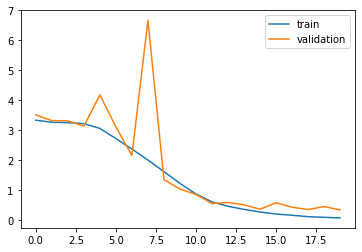

In [124]:
plot_train_process(train_loss, val_loss)

## Results

Now let's calculate metrics. I used CER cause i trust teachers who recommended it and I appreciate levenshtein distance for string difference

In [125]:
def decode_predictions(pred):
    pred = functional.softmax(pred, 2).argmax(2) 
    pred = pred.numpy().T 

    text_batch_tokens_new = []
    for text_tokens in pred:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [126]:
results_train = pd.DataFrame(columns=['actual', 'prediction', 'distance'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
cer_metric = []
with torch.no_grad():
    for image_batch, text_batch in train_loader:
        #make prediction
        pred = model(image_batch.to(device)) 
        text_batch_pred = [t.replace("-", "") for t in decode_predictions(pred.cpu())]
         #print(text_batch, text_batch_pred)
        # calc metric 
        batch_dist = []
        for i in range(len(text_batch)):
            dist = fastwer.score_sent(text_batch[i], text_batch_pred[i], char_level=True)
            batch_dist.append(dist)
        cer_metric.append(batch_dist)
        #make a dataset of what was recognized and what actually should be 
        df = pd.DataFrame(columns=['actual', 'prediction', 'distance'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        df['distance'] = batch_dist
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

This is a dataframe which has an actual captcha, the one which was predicted and theirs distance, as u can see the results are pretty good.

In [127]:
results_train

,actual,prediction,distance
0,nbmx7,nbmxx7,16.6667
1,ccf2w,ccf2w,0.0000
2,n6nn2,n6nn2,0.0000
3,bc8nf,bc8nf,0.0000
4,8cccc,8cccc,0.0000
...,...,...,...
851,5bgp2,5bgp2,0.0000
852,8e32m,8e32m,0.0000
853,c4bgd,c4bgd,0.0000
854,3fbxd,3fbxd,0.0000


Let's take a look at the worst recognized ones

In [129]:
results_train.sort_values(by='distance', ascending=False)

,actual,prediction,distance
705,x6b5m,x6bb5mm,28.5714
443,fcmem,fcmmemm,28.5714
389,m8gmx,m8gmmxx,28.5714
330,ddmyg,ddmmyyg,28.5714
318,3nw7w,3nww7ww,28.5714
...,...,...,...
410,d22y5,d22y5,0.0000
411,wg625,wg625,0.0000
115,x8xnp,x8xnp,0.0000
114,3mxdn,3mxdn,0.0000


Most of the "bad" cases for your nn is double letters one after another.Maybe data augmentation would help?.

<img src="fascinating-star-trek.gif.gif" width="750" align="center">
I find this task very fascinating, even though I an still not very familiar with easy creating perfect layers structure. During this lab as u could see I have bumped into some moments I didn't get right. Waiting for the critics and advises for my work!